In [1]:
from fenics import *
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Modal analysis of a cantilever beam
$
\begin{array}{c|c}
  \mathfrak{B} & \mathscr{A} \\ 
  \hline
  \mathcal{R} & \mathbb{E} \\ 
  \hline
  \mathrm{N} & \mathit{D} 
\end{array}
$

In this notebook we will look at a cantilever beam and apply modal analysis to find the response of the beam over time.

### Parameters and material model
A beam is chosen with length 1. Gravity causes body loads and 

The material model is chosen to be linear Hookean strain model.

In [2]:
# Scaled variables
L = 1.; W = 0.05
rho = 1.
# Define gravity
g = 0. #9.81
# Define applied surface load
F_a = 100.
Pf = F_a / W**2

# Elasticity parameters
E, nu = 1.e6, 0.3
# Lamé parameters
mu, lambda_ = Constant(E/(2*(1 + nu))), Constant(E*nu/((1 + nu)*(1 - 2*nu)))

# Define strain and stress
def epsilon(u):
    return 0.5*(nabla_grad(u) + nabla_grad(u).T)
    #return sym(nabla_grad(u))

def sigma(u):
    return lambda_*nabla_div(u)*Identity(d) + 2*mu*epsilon(u)

### Mesh
The mesh is defined as a rectangle in 2D to represent a beam and first order Lagrange elements are defined over the domain. The domain is clamped on the left hand side and a load is applied on the right hand side, for this purpose the left and right sides of the domain are marked.

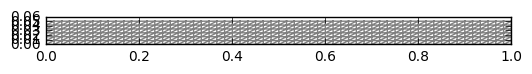

In [3]:
P0 = Point(0., 0.)
P1 = Point(L, W)
d = 2

# Define clamped boundary condition
tol = 1E-14
def clamped_boundary(x, on_boundary):
    return on_boundary and x[0] < tol

dens = 6
nx = int(dens*10)
ny = int(dens)

# Create mesh and define function space
mesh = RectangleMesh(P0, P1, nx, ny)
V = VectorFunctionSpace(mesh, 'P', 1)
plot(mesh)

# Mark boundary subdomians
class BoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (near(x[0], 0.))
    
class BoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (near(x[0], L))

# set boundary markers
boundary_markers = FacetFunction('size_t', mesh)
left = BoundaryLeft()
left.mark(boundary_markers, 0)
right = BoundaryRight()
right.mark(boundary_markers, 1)

# Define measure ds to apply markers
ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)

# Define boundary conditions on the domain V
c = Constant((0., 0.))
bcl = DirichletBC(V, c, left)
bc = [bcl]

### Problem definition
The problem is defined as a cantilever beam which is clamped at $x=0$.


The integral formulation for the static problem reads:
$$
\text{find }u\in V \text{  with } V := H^1_0(\Omega)
$$
$$
\int_{\Omega} \left(\langle \sigma(\mathbf{u}), \epsilon(\mathbf{v}) \rangle \right) \text{d}x = \int_{\Omega} \langle \mathbf{b} , \mathbf{v} \rangle \text{d}x + \int_{\partial \Omega} \langle \mathbf{t}, \mathbf{v} \rangle \text{d}s \qquad \forall v \in V
$$

Rewriting in the variational formulation gives:
$$
\text{find }u\in V \text{  with } V := H^1_0(\Omega)
$$
$$
a(u, v) = L(v) \qquad \forall v \in V
$$
$$
a(u,v) = \int_{\Omega}  \langle \sigma(\mathbf{u}), \epsilon(\mathbf{v}) \rangle \text{d}x
$$
$$
L(v) = \int_{\Omega} \langle \mathbf{b} , \mathbf{v} \rangle \text{d}x + \int_{\partial \Omega} \langle \mathbf{t}, \mathbf{v} \rangle \text{d}s
$$



In [4]:
# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)

b = Constant((0., -g))
T = Constant((-Pf, 0.))

a = inner(sigma(u), epsilon(v))*dx
Le = dot(b, v)*dx + dot(T, v)*ds(1)

# Compute solution
u = Function(V)
solve(a == Le, u, bc)

The problem is solved using Fenics's solve function and the maximum and minimum displacements is printed below along with a plot of the displacement.

Force                 100.0   Pressure    40000.0
minimum displacement  -0.0363697691029
maximum displacement  0.000331129077345


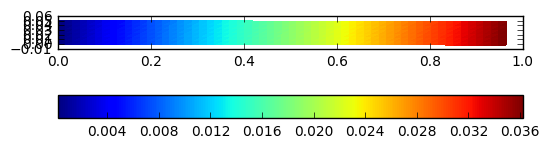

In [5]:
print "Force                ", F_a, "  Pressure   ", Pf
print "minimum displacement ", u.vector().min()
print "maximum displacement ", u.vector().max()

plt.figure()
ax = plot(u,mode="displacement")
cbar = plt.colorbar(ax, orientation='horizontal')
plt.show()

The stress in axial direction of the beam should be the value of <code>Pf
</code> which in the current case is 40000.

We can now calculate the stress using $$ \pmb{\sigma}(\mathbf{u}) = \lambda  \Delta (\mathbf{u})  \cdot \mathbf{I} + 2 \mu  \pmb{\mathcal{E}}(\mathbf{u}) $$

The axial stress is plotted in the segment below.

<function matplotlib.pyplot.show>

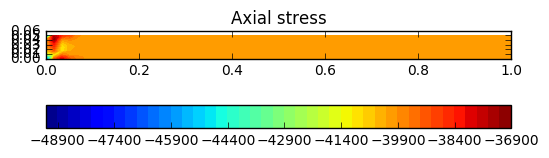

In [6]:
# calculate stress due to displacement
sigma_u = sigma(u)

fig = plt.figure()
ttl = "Axial stress"
ax = plot(sigma_u[0, 0], title=ttl)
cbar = plt.colorbar(ax, orientation='horizontal')
plt.show

### Construction of matrices
The mass and stiffness matrices and load vector are constructed by evaluating the variational formulation at each point in the mesh. These function are defined on either $(u,v)$ or only $v$ in case of the load vector.

To set up the matrices needed for modal analysis we will have a look at the components over the domain:

+ The mass is defined by the density: $\rho \langle u, v \rangle dx $
+ Stiffness is defined by the inner product of the stress and strain: $ \langle \sigma(\mathbf{u}), \epsilon(\mathbf{v}) \rangle dx $
+ The external load is defined as: $ \langle \mathbf{b}, \mathbf{v} \rangle dx + \langle \mathbf{t}, \mathbf{v} \rangle ds_r $

In [7]:
def m(u,v):
    return rho*dot(u,v)*dx
def k(u,v):
    return inner(sigma(u),epsilon(v))*dx
def l(v):
    return dot(b, v)*dx + dot(T, v)*ds(1)

Now the matrices are assembled over the domain using the trial and test functions. The stiffness and mass matrix are assembled using PETSc:

In [8]:
# Define functions
ut = TrialFunction(V)
v = TestFunction(V)

# Define matrices
A_m = PETScMatrix()
A_k = PETScMatrix()
be = PETScVector()

# Assemble system
assemble_system(m(ut,v), Le, bc, A_tensor=A_m, b_tensor=be);
assemble_system(k(ut,v), Le, bc, A_tensor=A_k, b_tensor=be);

### Eigenvalue problem
Using the definition of matrices in the form $\mathbf{x} = \sum_n \mathbf{X}_n q_n(t)$ where $\mathbf{X}_n$ is the modal vector and $q_n(t)$ is the time component.

$$
\sum_i \mathbf{M} \mathbf{X}_i \ddot(q)_i(t)  + \mathbf{K}  \mathbf{X}_i q_i(t) = \mathbf{0}
$$

Using the ansatz: $q_i(t) = A_i \sin \omega_i t + B_i \cos \omega_i t$ this leads to $\ddot{q}_i(t) = -\omega^2 q_i(t)$, which leads to the following eigenvalue problem:

$$
\left( \mathbf{K} - \omega^2_i \mathbf{M} \right) \mathbf{q}_i = \mathbf{0}
$$

The eigenvalue problem is evaluated using the SLEPc eigensolver and several options are applied as shown below:

In [9]:
# Define solver and solve EV problem
solver = SLEPcEigenSolver(A_k,A_m)
solver.parameters["spectrum"] = "target magnitude"
solver.parameters["spectral_transform"] = "shift-and-invert"
solver.parameters["spectral_shift"] = 0.
neigs = 50
solver.solve(neigs)

Modes are extracted, care is taken that spurious modes due to the boundary conditions (resulting in a value $1.$) are not counted

In [10]:
# Extract and plot modes
modes=[]
eigvalues=[]
vtkfile = File('Modes/modes.pvd')  
for md in range(neigs):
    r, c, rx, cx = solver.get_eigenpair(md)
    # Initialize function and assign eigenvector
    if not (r > 1.-1.e-8 and r < 1.+1.e-8):
        mode = Function(V)
        mode.rename("mode",'mode')
        mode.vector()[:] = rx
        modes.append(mode)
        eigvalues.append(r)
        # Save solution to file in VTK format
        #vtkfile = File('Modes/mode{}.pvd'.format(md))   # create VTK file
        vtkfile << (mode, sqrt(r))    
        del(mode)
        # print("eigenvalue mode ", md, " ", r, "     Frequency: ", sqrt(r))

### Modal projection
Using a number of modes, we can project the problem in the modal domain. Then the modal mass and stiffness matrices are assembled.


### Modal displacement method
$$
\mathbf{M} \ddot{\mathbf{x}}(t) + \mathbf{K} \mathbf{x} = \mathbf{F}
$$

Introduce modes:
$$
\omega^2 \mathbf{M} \mathbf{X} = \mathbf{K} \mathbf{X} 
$$

$$
x(t) = \sum_n X_n q_n(t) 
$$

$$
\ddot{x}(t) = \sum_n  X_n \ddot{q}_n(t)
$$

or using $$\mathbf{q} = \begin{Bmatrix} q_1(t) \\
q_2(t) \\
\vdots \\
q_n(t)
\end{Bmatrix}
$$

$$
\mathbf{M} \mathbf{X} \ddot{\mathbf{q}}(t) + \mathbf{K} \mathbf{X} \mathbf{q} = \mathbf{F}
$$

$$
\mathbf{X}^T \mathbf{M} \mathbf{X} \ddot{\mathbf{q}}(t) + \mathbf{X}^T \mathbf{K} \mathbf{X} \mathbf{q} = \mathbf{X}^T \mathbf{F}
$$

Using the fact that
$$
\begin{align}
\mathbf{X}^T \mathbf{M} \mathbf{X} =& \mathbf{I} \\
\mathbf{X}^T \mathbf{K} \mathbf{X} =& \left[\nwarrow \omega^2 \searrow \right] 
\end{align}
$$
and define the modal force vector:
$$
\mathbf{Q}(t) = \mathbf{X}^T \mathbf{F}(t)
$$

$$
\mathbf{I} \ddot{\mathbf{q}}(t) + \left[\nwarrow \omega^2 \searrow \right] \mathbf{q} = \mathbf{X}^T \mathbf{F}
$$

$$
\ddot{q}_i(t) + \omega^2_i q_i(t) = Q_i(t) \qquad i = 1,2,...,n
$$

$$
q_i(t) = q_i(0)\cos \omega_it + \left( \frac{\dot{q}(0)}{\omega_i} \right) \sin \omega_i t + \frac{1}{\omega_i} \int_0^t Q_i(\tau)\sin\omega_i(t - \tau) \text{d}\tau
$$

In case of a constant load:

$$
Q_i(t) = Q_i
$$

Finding the particular solution due to the forced terms:
$$
\begin{align}
x_Q = & \frac{1}{\omega_i} \int_0^t Q_i \sin\omega_i(t - \tau) \text{d}\tau \\
x_Q = & -\frac{Q_i}{\omega_i^2} \int_0^t \sin\omega_i(t - \tau) \text{d}\tau \\
x_Q = & -\frac{Q_i}{\omega_i^2} \left( 1 - \cos t \right)
\end{align}
$$

An important aspect is the number of modes that are used to project the system on. 

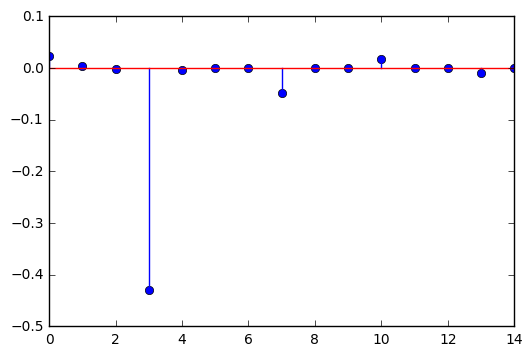

In [11]:
# Set up modal mass, stiffness and load matrices
nmodes = 15
M = np.zeros([nmodes,nmodes])
K = np.zeros([nmodes,nmodes])
F = np.zeros(nmodes)

for i in range(nmodes):
    F[i] = assemble(l(modes[i]))
    for j in range(nmodes):
        M[i,j]=assemble(m(modes[i],modes[j]))
        K[i,j]=assemble(k(modes[i],modes[j]))

def x_stat():
    return np.dot(np.linalg.inv(K), F)

c_0 = x_stat()

cm = []
for i in range(nmodes):
#    plot(modes[i]*c_0[i],mode="displacement")
#    plt.show()
    cm.append(modes[i]*c_0[i])

plt.stem(c_0)
plt.show()

After finding the modes and the static particular solution due to static forcing 

For static modes the participation factor is found easily by:

$$
\sum_i c_i  = \mathbf{K}^{-1} \mathbf{f}(0) 
$$

Using the participation factor $c_i$ per mode we can plot the modes:

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


<function matplotlib.pyplot.show>

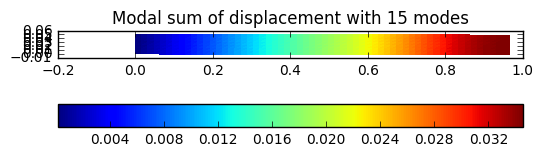

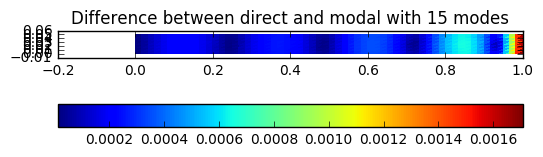

In [12]:
fig = plt.figure()
ttl="Modal sum of displacement with " + str(nmodes) + " modes"
plt.title(ttl)
ax = plot(sum(cm), mode='displacement')
cbar = plt.colorbar(ax, orientation='horizontal')
plt.show

#fig = plt.figure()
#plt.title("Direct computation of displacement")
#ax = plot(u, mode='displacement')
#cbar = plt.colorbar(ax, orientation='horizontal')
#plt.show

fig = plt.figure()
ttl="Difference between direct and modal with " + str(nmodes) + " modes"
plt.title(ttl)
ax = plot((u - sum(cm)), mode='displacement')
cbar = plt.colorbar(ax, orientation='horizontal')
plt.show

Modes over time are still a shit

What I need to do:
+ multiply modes with the participation factor (and harmonic) over time
+ visualize modes over time (animation?)
+ only showing participation tells us nothing because the way the mode itself is defined is of importance

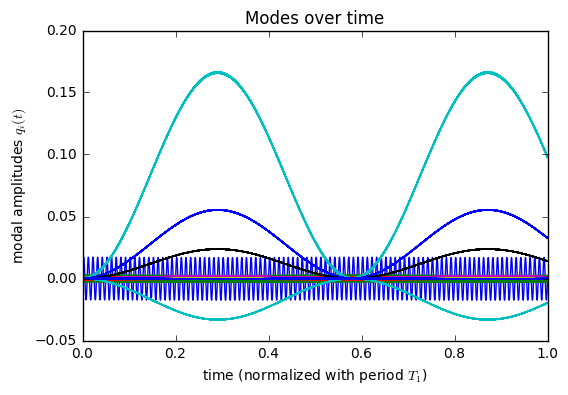

(1000000, 15)


In [13]:
x_init = np.zeros(nmodes)
v_init = np.ones(nmodes)
omega = np.array(eigvalues[:nmodes])**0.5

def q_cons(t):
    x_hom = x_init * np.cos(omega * t) + v_init / omega * np.sin(omega * t)
    x_part = - F / omega * (1 - np.cos(t))
    return x_hom + x_part


n_periods = 100
T_1 = n_periods * 2*np.pi / omega[0]  # first period

n_ts = int(1e4*n_periods)
ts = np.linspace(0, T_1, n_ts).reshape(n_ts,1).repeat(nmodes, axis=1)
q_out = q_cons(ts)

plt.figure()
plt.title("Modes over time")
plt.ylabel("modal amplitudes $q_i(t)$")
plt.xlabel(r"time (normalized with period $T_1$)")
plt.plot(ts/T_1, q_out)
plt.show()

print(q_out.shape)

In [14]:
max_vals = np.max(q_out, axis=0)
min_vals = np.min(q_out, axis=0)
amps = max_vals - min_vals

print(amps)

[ 0.03473282  0.00588918  0.00241644  0.16727044  0.0026744   0.00085769
  0.00069017  0.0557601   0.00077302  0.00064369  0.03345756  0.0002434
  0.00023931  0.02390197  0.00036617]


To see that it does not matter how a mode is defined we will plot the first mode shape and the first mode shape as the system is projected using the participation factor. The 'raw' mode shape results in a shape that seems to be gigantic but when using the participation factor the mode turns out to only have a small displacement.

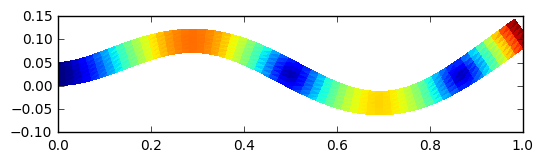

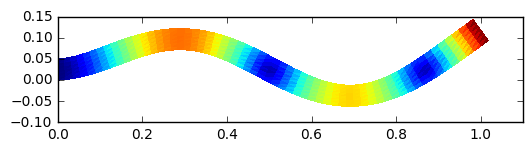

In [15]:
md = 2

plot(modes[md], mode='displacement')
plt.xlim([0, 1])
plt.show()

plot(modes[md]/modes[md].vector().norm("l2"), mode='displacement')
plt.xlim([0, 1.1])
plt.show()

In [16]:
modes[md].vector().norm("l2")

1.0